In [41]:
import warnings
warnings.filterwarnings("ignore")

import re
import ast
import nltk
import random
import numpy as np
import pandas as pd
import json
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from random import randint
from nltk import word_tokenize, FreqDist
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score
from nltk.stem import WordNetLemmatizer
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB

# Data Preprocessing

In [2]:
#loading dataset and removing unwanted features
dataset = pd.read_csv(f'Book_summary.csv', encoding= 'unicode_escape')
dataset = dataset.drop(['Publication Date', 'Wikibedia ID', 'Freebase ID'], axis=1)
dataset

,Book title,Book author,Genre,Summary
0,Animal Farm,George Orwell,"{""/m/016lj8"": ""Roman à clef"", ""/m/06nbt"": ""Sat...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,An Enquiry Concerning Human Understanding,David Hume,NaN,The argument of the Enquiry proceeds by a ser...
4,A Fire Upon the Deep,Vernor Vinge,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
...,...,...,...,...
16554,Under Wildwood,Colin Meloy,NaN,"Prue McKeel, having rescued her brother from ..."
16555,Transfer of Power,Vince Flynn,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
16556,Decoded,Jay-Z,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...
16557,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,NaN,Colbert addresses topics including Wall Stree...


In [3]:
#check for nulls and removing nans
dataset.isnull().count()
dataset = dataset.dropna(axis = 0)
dataset = dataset.reset_index(drop=True)
dataset

,Book title,Book author,Genre,Summary
0,Animal Farm,George Orwell,"{""/m/016lj8"": ""Roman à clef"", ""/m/06nbt"": ""Sat...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,A Fire Upon the Deep,Vernor Vinge,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
4,All Quiet on the Western Front,Erich Maria Remarque,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul B??umer, a G..."
...,...,...,...,...
12050,The Third Lynx,Timothy Zahn,"{""/m/06n90"": ""Science Fiction""}",The story starts with former government agent...
12051,Remote Control,Andy McNab,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction...",The series follows the character of Nick Ston...
12052,Transfer of Power,Vince Flynn,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
12053,Decoded,Jay-Z,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...


In [7]:
def cleaned_text(raw_text):
    raw_text = re.findall(r"[a-zA-Z]+", raw_text)
    raw_text = " ".join(raw_text).lower()
    tokens = word_tokenize(raw_text)
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return tokens

In [8]:
def convert_list_to_string(org_list, seperator=' '):
    """ Convert list to string, by joining all item in list with given separator.
        Returns the concatenated string """
    return seperator.join(org_list)

In [9]:
cleaned_dataset = dataset.copy()
cleaned_dataset.insert(loc=3, column='Book summary', value="")
unique_genres = {}

for index, row in cleaned_dataset.iterrows():
    row["Genre"] = list(ast.literal_eval(row["Genre"]).values())
    for item in row["Genre"]:
        if item not in unique_genres:
            unique_genres[item] = 1
        else:
            unique_genres[item] += 1
            
    tokens = cleaned_text(str(row['Summary']))
    # Convert list of strings to string
    row['Book summary'] = convert_list_to_string(tokens)

for index, row in cleaned_dataset.iterrows():
    if len(row["Genre"]) == 1:
        row["Genre"] = row["Genre"][0]
    else :
        max_ = 0
        pop_genre = ""
        for item in row["Genre"]:
            if unique_genres[item] > max_:
                max_ = unique_genres[item]
                pop_genre = item
        row["Genre"] = pop_genre

cleaned_dataset = pd.DataFrame(cleaned_dataset)
cleaned_dataset.drop('Summary', axis=1)

,Book title,Book author,Genre,Book summary
0,Animal Farm,George Orwell,Fiction,old major old boar manor farm call animal farm...
1,A Clockwork Orange,Anthony Burgess,Fiction,alex teenager living near future england lead ...
2,The Plague,Albert Camus,Fiction,text plague divided five part town oran thousa...
3,A Fire Upon the Deep,Vernor Vinge,Fiction,novel posit space around milky way divided con...
4,All Quiet on the Western Front,Erich Maria Remarque,War novel,book tell story paul b umer german soldier urg...
...,...,...,...,...
12050,The Third Lynx,Timothy Zahn,Science Fiction,story start former government agent frank comp...
12051,Remote Control,Andy McNab,Fiction,series follows character nick stone ex militar...
12052,Transfer of Power,Vince Flynn,Fiction,reader first meet rapp covert operation iran d...
12053,Decoded,Jay-Z,Autobiography,book follows rough chronological order switchi...


In [10]:
cleaned_dataset.groupby(["Genre"]).count()

,Book title,Book author,Book summary,Summary
Genre,,,,
Absurdist fiction,2,2,2,2
Adventure novel,56,56,56,56
Albino bias,1,1,1,1
Alien invasion,1,1,1,1
Alternate history,17,17,17,17
...,...,...,...,...
War novel,26,26,26,26
Western,9,9,9,9
Western fiction,8,8,8,8


# Feature Engineering

## TF-IDF

In [ ]:
def tfidf_model(data):
    tfIdf_vectorizer = TfidfVectorizer(use_idf=True, min_df=0.05)

    tfidf_model = tfIdf_vectorizer.fit_transform(data)
    tfidf_features = pd.DataFrame(tfidf_model.toarray(), columns = tfIdf_vectorizer.get_feature_names())
    return tfidf_features

In [ ]:
tfidf_features = tfidf_model(cleaned_dataset['Book summary'])
tfidf_features

## Doc2Vec

In [ ]:
def doc2vec_model(data):  
    documents = [doc for doc in data]
    tagged_documents = [TaggedDocument(tokens, [i]) for i, tokens in enumerate(documents)]

    doc2vec_model = Doc2Vec(vector_size=300, min_count=2, epochs=40)
    doc2vec_model.build_vocab(tagged_documents)
    doc2vec_model.train(tagged_documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

    doc2vec_features = [doc2vec_model.infer_vector(doc.split()) for doc in documents]
    doc2vec_features = np.array(doc2vec_features)
    
    return pd.DataFrame(doc2vec_features)

In [ ]:
doc2vec_features = doc2vec_model(cleaned_dataset["Book summary"])
doc2vec_features

## TF-IDF + Doc2Vec

In [ ]:
tfidf_doc2vec_features = pd.concat([tfidf_features, doc2vec_features], axis=1)

# Clustering

In [ ]:
import matplotlib.cm as cm
from scipy.spatial.distance import cosine
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from yellowbrick.cluster import KElbowVisualizer

In [ ]:
model = KMeans(n_clusters = 30).fit_predict(doc2vec_features)

In [ ]:
model2 = DBSCAN(eps=0.1, min_samples=3, metric="cosine").fit_predict(tfidf_doc2vec_features)

In [ ]:
np.unique(model2)

In [ ]:
indices = doc2vec_features[model2 == 0].index

In [ ]:
indices

In [ ]:
cosine_scores = []
for ind, val in enumerate(indices):
    cosine_score = cosine(doc2vec_features[model2 == 0].iloc[0], doc2vec_features[model2 == 0].iloc[ind])
    cosine_scores.append(cosine_score)
    
print(cosine_scores)

In [ ]:
np.argpartition(cosine_scores, 4)[:4]

In [ ]:
ya = doc2vec_features[model2 == 0].iloc[np.argpartition(cosine_scores, 4)[:4]].index

In [ ]:
ya

In [ ]:
cleaned_dataset.iloc[ya]

# Classification

In [12]:
def tfidf_model_classif(data_train, data_test):
    tfIdf_vectorizer = TfidfVectorizer(use_idf=True, min_df=0.05)
    tfidf_model = tfIdf_vectorizer.fit(data_train)
    tfidf_train = tfIdf_vectorizer.transform(data_train)
    tfidf_train = pd.DataFrame(tfidf_train.toarray(), columns = tfIdf_vectorizer.get_feature_names())
    tfidf_test = tfIdf_vectorizer.transform(data_test)
    tfidf_test = pd.DataFrame(tfidf_test.toarray(), columns = tfIdf_vectorizer.get_feature_names())
    return tfidf_train, tfidf_test, tfidf_model

In [13]:
def doc2vec_model_classif(data):  
    documents = [doc for doc in data]
    tagged_documents = [TaggedDocument(tokens, [i]) for i, tokens in enumerate(documents)]

    doc2vec_model = Doc2Vec(vector_size=300, min_count=2, epochs=40)
    doc2vec_model.build_vocab(tagged_documents)
    doc2vec_model.train(tagged_documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

    doc2vec_features = [doc2vec_model.infer_vector(doc.split()) for doc in documents]
    doc2vec_features = np.array(doc2vec_features)
    
    return pd.DataFrame(doc2vec_features)

In [14]:
def model_knn(x_train, y_train, x_test, y_test):
    classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2) #choosing Euclidean distance metric
    classifier.fit(x_train, y_train)
    ypred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, ypred)*100
    print(f'K-NN: {accuracy}')
    
    return classifier, ypred, accuracy

In [15]:
def model_svm(x_train, y_train, x_test, y_test):
    cs = SVC(kernel = 'rbf', random_state = 0)
    cs.fit(x_train, y_train)
    ypred = cs.predict(x_test)
    accuracy = accuracy_score(y_test, ypred)*100
    print(f'ٍSVM: {accuracy}')
    plot_confusion_matrix(cs, x_test, y_test)
    
    return cs, ypred, accuracy

In [63]:
def train_test_data(xdata, ydata):
    x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size = 0.3, random_state=0)
    x_train = x_train.reset_index(drop = True)
    x_test = x_test.reset_index(drop = True)
    return x_train, x_test, y_train, y_test

In [28]:
def plt_bar(labels_name, yvalues, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(20, 20))
    plt.bar(labels_name, yvalues)
    plt.title(title, fontsize = 'x-large')
    plt.ylabel(ylabel, fontsize = 'x-large')
    plt.xlabel(xlabel, fontsize = 'x-large')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

# preprocessing data For classification process
preparing the data for binary classification classification

##### The genre row contains data stored in the Dictionary format
so, the following steps is to convert this data to a dictionary format to be accessible

In [17]:
list_genre = []
for i in dataset['Genre']:
    list_genre.append(list(json.loads(i).values())) # reading each cell's content and parse it

In [18]:
# creating the new Dataset dataframe
classif_dataset = pd.DataFrame(list(zip(cleaned_dataset['Book summary'].values, list_genre)), columns = ["Summary", "Genre"])
classif_dataset

,Summary,Genre
0,old major old boar manor farm call animal farm...,"[Roman à clef, Satire, Children's literature, ..."
1,alex teenager living near future england lead ...,"[Science Fiction, Novella, Speculative fiction..."
2,text plague divided five part town oran thousa...,"[Existentialism, Fiction, Absurdist fiction, N..."
3,novel posit space around milky way divided con...,"[Hard science fiction, Science Fiction, Specul..."
4,book tell story paul b umer german soldier urg...,"[War novel, Roman à clef]"
...,...,...
12050,story start former government agent frank comp...,[Science Fiction]
12051,series follows character nick stone ex militar...,"[Thriller, Fiction, Suspense]"
12052,reader first meet rapp covert operation iran d...,"[Thriller, Fiction]"
12053,book follows rough chronological order switchi...,[Autobiography]


In [23]:
all_genres = sum(list_genre,[])
len(set(all_genres))

221

In [24]:
all_genres = nltk.FreqDist() 
all_genres

FreqDist({})

In [25]:
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [26]:
g = all_genres_df.nlargest(columns="Count", n = 50) 

In [30]:
temp_list = []
for i in classif_dataset['Genre']:
    x = len(temp_list)
    for j in i:
        if 'fiction' in j.lower():
            temp_list.append('fiction')
            break
    if x == len(temp_list):
        temp_list.append('non fiction')

In [31]:
classif_dataset['New Genre'] = temp_list

In [32]:
classif_dataset

,Summary,Genre,New Genre
0,old major old boar manor farm call animal farm...,"[Roman à clef, Satire, Children's literature, ...",fiction
1,alex teenager living near future england lead ...,"[Science Fiction, Novella, Speculative fiction...",fiction
2,text plague divided five part town oran thousa...,"[Existentialism, Fiction, Absurdist fiction, N...",fiction
3,novel posit space around milky way divided con...,"[Hard science fiction, Science Fiction, Specul...",fiction
4,book tell story paul b umer german soldier urg...,"[War novel, Roman à clef]",non fiction
...,...,...,...
12050,story start former government agent frank comp...,[Science Fiction],fiction
12051,series follows character nick stone ex militar...,"[Thriller, Fiction, Suspense]",fiction
12052,reader first meet rapp covert operation iran d...,"[Thriller, Fiction]",fiction
12053,book follows rough chronological order switchi...,[Autobiography],non fiction


In [33]:
dataset = classif_dataset.drop(['Genre'], axis=1)
dataset = dataset.rename(columns={'New Genre': 'Genre'})
dataset

,Summary,Genre
0,old major old boar manor farm call animal farm...,fiction
1,alex teenager living near future england lead ...,fiction
2,text plague divided five part town oran thousa...,fiction
3,novel posit space around milky way divided con...,fiction
4,book tell story paul b umer german soldier urg...,non fiction
...,...,...
12050,story start former government agent frank comp...,fiction
12051,series follows character nick stone ex militar...,fiction
12052,reader first meet rapp covert operation iran d...,fiction
12053,book follows rough chronological order switchi...,non fiction


In [34]:
dataset['Genre'].value_counts()

fiction        8684
non fiction    3371
Name: Genre, dtype: int64

In [65]:
xtrain, xtest, ytrain, ytest = train_test_data(dataset['Summary'], dataset['Genre'])

# binary classification

# BOW

In [66]:
#xtrain, xtest, ytrain, ytest
def model_bow(data_train, data_test):
    bow_vectorizer = CountVectorizer()
    bow_train_model = bow_vectorizer.fit_transform(data_train)
    bow_features_train = pd.DataFrame(bow_train_model.toarray(), columns = bow_vectorizer.get_feature_names())
    
    bow_test_model = bow_vectorizer.transform(data_test)
    bow_features_test = pd.DataFrame(bow_test_model.toarray(), columns = bow_vectorizer.get_feature_names())
    return bow_features_train, bow_features_test

In [67]:
bow_train_data, bow_test_data = model_bow(xtrain, xtest)

72.40807298866464


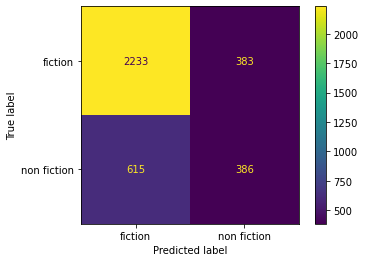

In [68]:
model = MultinomialNB()
#clf = OneVsRestClassifier(model)
model.fit(bow_train_data, ytrain)
ypred = model.predict(bow_test_data)
print(accuracy_score(ytest, ypred)*100)
plot_confusion_matrix(model, bow_test_data, ytest)

# under sampling

In [69]:
from imblearn.under_sampling import RandomUnderSampler

In [70]:
rus = RandomUnderSampler(random_state = 0, sampling_strategy = 'majority')
x_res_rus, y_res_rus = rus.fit_resample(bow_train_data, ytrain)

66.87862869781587


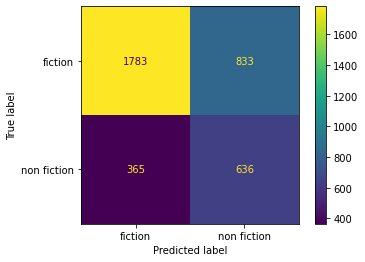

In [71]:
model = MultinomialNB()
#clf = OneVsRestClassifier(model)
model.fit(x_res_rus, y_res_rus)
ypred = model.predict(bow_test_data)
print(accuracy_score(ytest, ypred)*100)
plot_confusion_matrix(model, bow_test_data, ytest)

# Error analysis

In [133]:
def error_analysis(dataset_test, model_label_pred, actual):
    model_label_pred = pd.DataFrame(dataset_test)
    model_label_pred["Prediction"] = model_label_pred
    model_label_pred["Genre"] = actual
    #df = pd.concat([dataset_test, model_label_pred], axis = 1, sort = False)
    wrong_pred = model_label_pred.loc[df["Genre"] != df["Prediction"]]
    
    return wrong_pred

In [134]:
# print(accuracy_score(ytest, ypred_doc2vec))
# print(f1_score(ytest, ypred_doc2vec, average = 'macro'))
# print(recall_score(ytest, ypred_doc2vec, average = 'macro'))
# print(precision_score(ytest, ypred_doc2vec, average = 'macro'))

In [135]:
df = error_analysis(xtest, ypred, ytest)
df

,Summary,Prediction,Genre
0,novel sequel doyle book woman walked door desc...,novel sequel doyle book woman walked door desc...,NaN
1,conner perfect boy handsome amazing grade amaz...,conner perfect boy handsome amazing grade amaz...,NaN
2,told point view unnamed narrator story begin b...,told point view unnamed narrator story begin b...,NaN
3,alice whittaker rich dowdy career life lonely ...,alice whittaker rich dowdy career life lonely ...,NaN
4,gould thesis wonderful life chance one decisiv...,gould thesis wonderful life chance one decisiv...,NaN
...,...,...,...
3612,dug mundane transported magic land xanth play ...,dug mundane transported magic land xanth play ...,NaN
3613,book black teenager named andre anderson love ...,book black teenager named andre anderson love ...,NaN
3614,passion spent written three part primarily vie...,passion spent written three part primarily vie...,NaN
3615,younger brother navajo indian living arizona w...,younger brother navajo indian living arizona w...,NaN
